## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [1]:
import os
import math as m
import numpy as np
from numba import vectorize, float32, int32

@vectorize([float32(int32)], target='parallel', fastmath=True) 
def log(x):
    return m.log(x)

@vectorize([float32(int32)], target='parallel', fastmath=True) 
def exp(x):
    return m.exp(x)

A = np.array([2,5,10,3,8]).astype(np.int32) 

print(log(A))
print(exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exercise 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

Text(0.5, 1.0, 'Gaussian pdf')

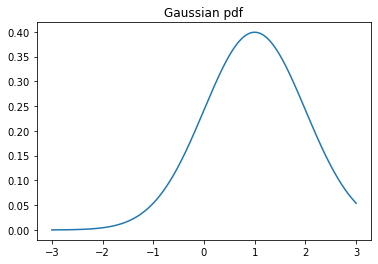

In [2]:
import matplotlib.pyplot as plt
import numpy as np


@vectorize([float32(float32)], target = 'parallel', fastmath = True)
def N(x):
    mean = 1
    sigma = 1
    return 1/(m.sqrt(2*np.pi)*sigma) * m.exp(-1/2*((x-mean)/sigma)**2)

size = 100000
x = np.linspace(-3, 3, size, dtype=np.float32)

plt.plot(x, N(x))
plt.title("Gaussian pdf")

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

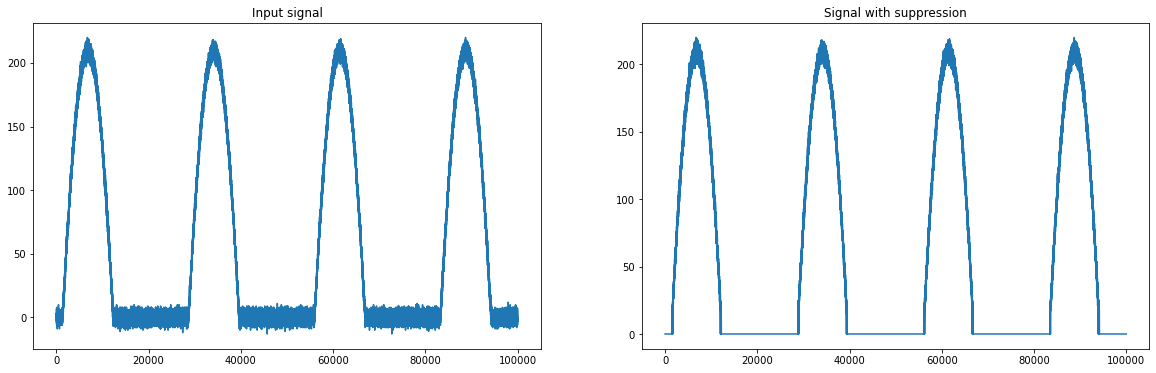

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
@vectorize([int32(int32)], target = 'parallel', fastmath = True)
def zero_suppression(x):
    return 0 if x < 15 else x

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].set_title("Input signal")
axs[0].plot(data)
axs[1].set_title("Signal with suppression")
axs[1].plot(zero_suppression(data))

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [4]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

from numba import jit
@jit(nopython = True)
def sigmoid(x, y):
    a = 1
    c = 0
    return np.tanh(a * (x.T).dot(y) + c)

print(sigmoid(X, Y))

[[0.58398828 0.70357737 0.83718102]
 [0.51385654 0.44301359 0.62037572]
 [0.53448944 0.70541316 0.83056415]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [5]:
from numba import cuda
@cuda.jit
def kernel_3d(matrix_3d):
    x, y, z = cuda.grid(3)
    if x < matrix_3d.shape[0] and y < matrix_3d.shape[1] and z < matrix_3d.shape[2]:
        matrix_3d[x, y, z] = m.cos(matrix_3d[x, y, z])

data = np.random.random((256, 256, 256))
        
threadsperblock = (16, 8, 4)
blockspergrid_x = int(np.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(np.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

kernel_3d[blockspergrid, threadsperblock](data)

print(data.shape)
print(data)

(256, 256, 256)
[[[0.80473502 0.94888816 0.67310014 ... 0.85247288 0.7399901  0.90440185]
  [0.98976544 0.58903798 0.63183381 ... 0.6358839  0.93497841 0.9943203 ]
  [0.93617422 0.73281786 0.85586862 ... 0.97343355 0.99993731 0.57829017]
  ...
  [0.93224271 0.97392682 0.99142941 ... 0.99402774 0.62368725 0.82262285]
  [0.99999814 0.95174255 0.99726612 ... 0.8587948  0.69514216 0.9354608 ]
  [0.99861389 0.67958199 0.90275177 ... 0.97402809 0.99118739 0.65734997]]

 [[0.93718769 0.9999807  0.76206134 ... 0.86107435 0.79010509 0.92119448]
  [0.99524453 0.62372945 0.86892885 ... 0.99416154 0.9987914  0.72159011]
  [0.93556333 0.83447368 0.9799848  ... 0.54794481 0.97876154 0.56704966]
  ...
  [0.70025479 0.9225564  0.63011673 ... 0.97102495 0.90344508 0.96654241]
  [0.9011945  0.99961967 0.76562673 ... 0.65137493 0.68949101 0.98618065]
  [0.97176054 0.90147627 0.95522442 ... 0.99405727 0.944487   0.95432687]]

 [[0.83616503 0.92084897 0.77655347 ... 0.7541553  0.98696668 0.91590107]
  [0.9

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [6]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(22, size=(24,12))
B = np.random.randint(22, size=(24,12))

# Configure the blocks
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,12))
matmul[blockspergrid, threadsperblock](A, B, C)

print(C)

[[1074.  755.  685.  919.  649.  491.  884. 1027.  772.  899.  795.  849.]
 [2121. 1633. 1440. 1349. 1010. 1052. 1779. 2065. 1217. 1632. 1689. 1654.]
 [1702. 1563. 1766. 1334. 1338. 1059. 1612. 1914. 1479. 1889. 1394. 1450.]
 [1122.  668.  901. 1043.  595.  320. 1074. 1199.  699.  932.  925. 1062.]
 [1723. 1600. 1213. 1638. 1110. 1134. 1508. 1796. 1368. 1856. 1338.  975.]
 [1703. 1132. 1218. 1151.  891.  913. 1457. 1533. 1061. 1466. 1399. 1226.]
 [1846. 1929. 1335. 1371. 1266. 1515. 1488. 2138. 1382. 1997. 1647. 1248.]
 [1655. 1629. 1335. 1520. 1067. 1196. 1326. 1480. 1040. 1644. 1053. 1184.]
 [1188.  984. 1062.  977.  812.  753. 1118. 1359.  651. 1283. 1020. 1114.]
 [1932. 1910. 1461. 1484. 1358. 1326. 1647. 2121. 1456. 2021. 1436. 1405.]
 [1658. 1177.  937.  989.  717.  836. 1395. 1473.  980. 1367. 1111. 1005.]
 [1761. 1516. 1243. 1231. 1117. 1461. 1591. 1624. 1123. 1931. 1511.  868.]
 [1907. 1378. 1162. 1328.  923.  969. 1476. 1676. 1276. 1591. 1264. 1295.]
 [1444. 1462. 1146.  977.